# Object Detection with Python
This notebook outlines how to do object detection using machine learning models in the Open Neural Network Exchange (ONNX) format. The model used is the You Only Look Once (YOLO) version 3 lite model. 

In [1]:

from io import BytesIO
from ipywebrtc import CameraStream, ImageRecorder
from ipywidgets import Image, HBox, Widget
import numpy as np
import onnxruntime as rt
import PIL.Image
import PIL.ImageDraw

In [4]:
%pylab inline
import cv2
import numpy as np
import onnxruntime as rt
import PIL.Image
import PIL.ImageDraw
# Single function imports to speed up loop
from cv2 import cvtColor, COLOR_BGR2RGB
from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


/home/pg787sp/.local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Object detection on a sample image

The following sample image is taken from the Common Objects in Context (COCO) dataset (test2017/000000068010.jpg). It contains three people in the foreground with additional people in the background. The Python Imaging Library (PIL) reads this image in RGB format with width and height values of 640 and 427 pixels.

![sample](sample.jpg)

Prior to processing the image with the model, the image must be preprocessed to have the correct height and width. The image is resized to the expected model input size of 416 by 416 pixels and padding is used to maintain the original aspect ratio. The preprocessed image looks like this:

![preprocessed](sample_preprocessed.jpg)

After processing teh image with model, and modifying the source image with the model output, the original image looks like this:

![preprocessed](sample_predicted.jpg)

In [5]:
#https://github.com/onnx/models/tree/master/vision/object_detection_segmentation/tiny_yolov3
def letterbox_image(image, size=[416, 416]):
    '''resize image with unchanged aspect ratio using padding'''
    iw, ih = image.size
    w, h = size
    scale = min(w/iw, h/ih)
    nw = int(iw*scale)
    nh = int(ih*scale)
    
    # resize image using bicubic interpolation
    image = image.resize((nw,nh), PIL.Image.BICUBIC)
    new_image = PIL.Image.new('RGB', size, (128,128,128))
    new_image.paste(image, ((w-nw)//2, (h-nh)//2))
    return new_image


def preprocess(img):
    # Convert image of size width, height, channels (uint8) to 1, channels, width, height (float32)
    image_data = np.array(img, dtype=np.float32).transpose([2, 0, 1]) / 255.
    # Clip the alpha channel if the source image has an additional channel
    return image_data[np.newaxis, :3, :, :]


def predict(img):
    image_data = preprocess(img)
    image_size = np.array([img.size[1], img.size[0]], dtype=np.float32)[np.newaxis, :]
    
    boxes, scores, indices = sess.run(None, {"input_1": image_data, "image_shape": image_size})

    out_boxes, out_scores, out_classes = [], [], []
    for idx_ in indices[0]:
        out_classes.append(idx_[1])
        out_scores.append(scores[tuple(idx_)])
        idx_1 = (idx_[0], idx_[2])
        out_boxes.append(boxes[idx_1])
    
    draw = PIL.ImageDraw.Draw(img)
    for box, score, class_idx in zip(out_boxes, out_scores, out_classes):
        draw.rectangle(((box[1], box[0]), (box[3], box[2])), outline="yellow")
        draw.text((box[1], box[0]), "{0}, {1:0.2f}%".format(class_names[class_idx], score * 100), fill='yellow')
    
    return img

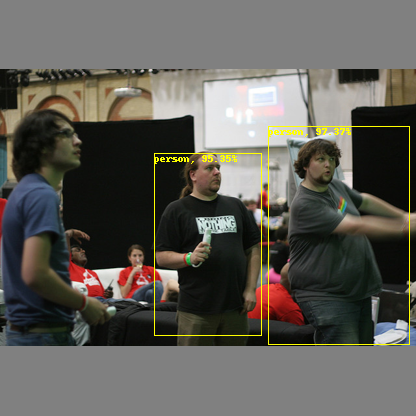

In [6]:
sess = rt.InferenceSession("yolov3-tiny.onnx")

with open("class_names.txt", "r") as f:
    class_names = [l.strip("\n") for l in f]
    
img = PIL.Image.open("sample.jpg")
predict(letterbox_image(img))

In [9]:
vc = cv2.VideoCapture(0)

is_capturing = vc.isOpened()

while(is_capturing):
    is_capturing, frame = vc.read()
    frame = cvtColor(frame, COLOR_BGR2RGB)
    predict(frame)
    axis("off")
    imshow(frame)
    show()
    clear_output(wait=True)

False


### Setup webcam video stream

The cell below creates a video stream from your webcam using WebRTC.

In [13]:
#https://github.com/QuantStack/quantstack-talks/edit/master/2018-11-14-PyParis-widgets/notebooks/6.ipywebrtc.ipynb
    
camera = CameraStream(
    constraints = {
        "facing_mode": "user",
        "audio": False,
        "video": {"width": 416, "height": 416}
    }
)

image_recorder = ImageRecorder(stream=camera)
image_output = Image()
stop_process = False

def process_image(_):
    # Flag to stop performing object detection
    if stop_process:
        return
    
    # Read the current value from the image_recorder
    img = PIL.Image.open(BytesIO(image_recorder.image.value))
    
    # Run the image through the model
    predict(img)
    
    # Write labelled image to output buffer
    f = BytesIO()
    img.save(f, format='png')
    image_output.value = f.getvalue()
    image_recorder.recording = True

image_recorder.image.observe(process_image, names=['value'])

HBox([image_output, image_recorder])

In [15]:
stop_process = True

### Clean up

In [16]:
Widget.close_all()